# import packages

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse.linalg import svds
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

# Data Exploration & Processing



In [44]:
# Read data
df = pd.read_csv('https://raw.githubusercontent.com/15love39/Book-Recommendation-System-for-MAS651/refs/heads/main/data.csv')

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6810 entries, 0 to 6809
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   isbn13          6810 non-null   int64  
 1   isbn10          6810 non-null   object 
 2   title           6810 non-null   object 
 3   subtitle        2381 non-null   object 
 4   authors         6738 non-null   object 
 5   categories      6711 non-null   object 
 6   thumbnail       6481 non-null   object 
 7   description     6548 non-null   object 
 8   published_year  6804 non-null   float64
 9   average_rating  6767 non-null   float64
 10  num_pages       6767 non-null   float64
 11  ratings_count   6767 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 638.6+ KB


In [46]:
df.head()

,isbn13,isbn10,title,subtitle,authors,categories,thumbnail,description,published_year,average_rating,num_pages,ratings_count
0,9780002005883,0002005883,Gilead,NaN,Marilynne Robinson,Fiction,http://books.google.com/books/content?id=KQZCP...,A NOVEL THAT READERS and critics have been eag...,2004.0,3.85,247.0,361.0
1,9780002261982,0002261987,Spider's Web,A Novel,Charles Osborne;Agatha Christie,Detective and mystery stories,http://books.google.com/books/content?id=gA5GP...,A new 'Christie for Christmas' -- a full-lengt...,2000.0,3.83,241.0,5164.0
2,9780006163831,0006163831,The One Tree,NaN,Stephen R. Donaldson,American fiction,http://books.google.com/books/content?id=OmQaw...,Volume Two of Stephen Donaldson's acclaimed se...,1982.0,3.97,479.0,172.0
3,9780006178736,0006178731,Rage of angels,NaN,Sidney Sheldon,Fiction,http://books.google.com/books/content?id=FKo2T...,"A memorable, mesmerizing heroine Jennifer -- b...",1993.0,3.93,512.0,29532.0
4,9780006280897,0006280897,The Four Loves,NaN,Clive Staples Lewis,Christian life,http://books.google.com/books/content?id=XhQ5X...,Lewis' work on the nature of love divides love...,2002.0,4.15,170.0,33684.0


In [47]:
df.describe()

,isbn13,published_year,average_rating,num_pages,ratings_count
count,6.810000e+03,6804.000000,6767.000000,6767.000000,6.767000e+03
mean,9.780677e+12,1998.630364,3.933284,348.181026,2.106910e+04
std,6.068911e+08,10.484257,0.331352,242.376783,1.376207e+05
min,9.780002e+12,1853.000000,0.000000,0.000000,0.000000e+00
25%,9.780330e+12,1996.000000,3.770000,208.000000,1.590000e+02
50%,9.780553e+12,2002.000000,3.960000,304.000000,1.018000e+03
75%,9.780810e+12,2005.000000,4.130000,420.000000,5.992500e+03
max,9.789042e+12,2019.000000,5.000000,3342.000000,5.629932e+06


In [48]:
df.isnull().sum()

,0
isbn13,0
isbn10,0
title,0
subtitle,4429
authors,72
categories,99
thumbnail,329
description,262
published_year,6
average_rating,43


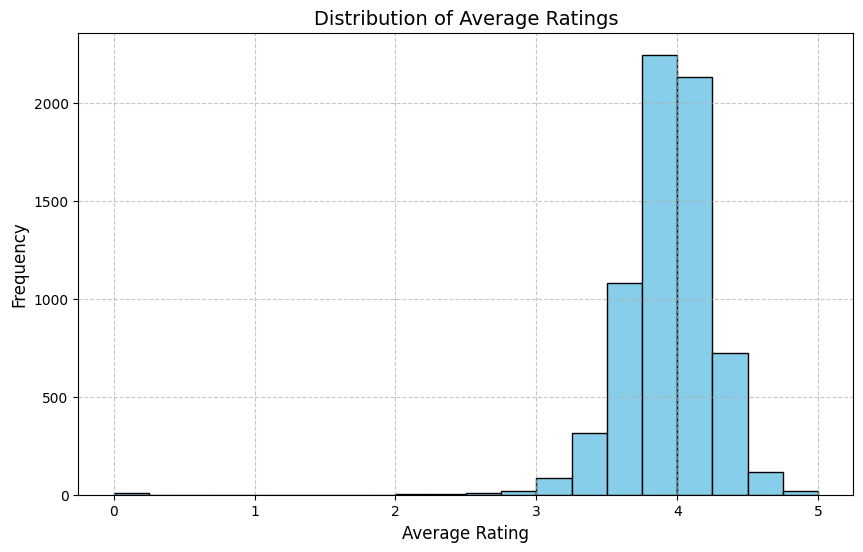

In [49]:
# 1. Histogram of average_rating
plt.figure(figsize=(10, 6))
plt.hist(df['average_rating'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Average Ratings', fontsize=14)
plt.xlabel('Average Rating', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

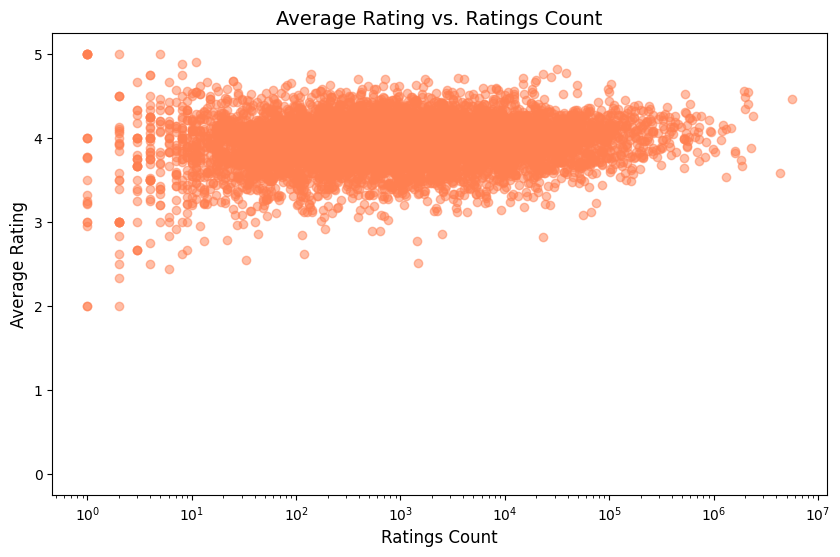

In [50]:
# 2. Scatter plot of average_rating vs. ratings_count
plt.figure(figsize=(10, 6))
plt.scatter(df['ratings_count'], df['average_rating'], color='coral', alpha=0.5)
plt.title('Average Rating vs. Ratings Count', fontsize=14)
plt.xlabel('Ratings Count', fontsize=12)
plt.ylabel('Average Rating', fontsize=12)
plt.xscale('log') # Log scale for ratings_count due to wide range plt.grid(True, linestyle='--', alpha=0.7) # Highlight "The Four Loves" as an example four_loves_idx = df[df['title'] == 'The Four Loves'].index[0] plt.scatter(df['ratings_count'][four_loves_idx], df['average_rating'][four_loves_idx], color='red', s=100, label='The Four Loves (33,684 ratings)') plt.legend()
plt.show()

## Collaborative Filtering

In [51]:
# Select only rating-related features for collaborative filtering
df['average_rating'] = df['average_rating'].fillna(df['average_rating'].mean())
df['ratings_count'] = df['ratings_count'].fillna(0)

# Normalize rating data (to prevent large value ranges)
df['norm_rating'] = df['average_rating'] / df['average_rating'].max()
df['norm_ratings_count'] = df['ratings_count'] / df['ratings_count'].max()

## Content-Based

In [52]:
# Select relevant features for content-based recommendation
selected_features = ['title', 'authors', 'categories', 'description']

# Handle missing values
for feature in selected_features:
    df[feature] = df[feature].fillna('')

# Combine features into a single text data column
df['content'] = df['title'] + ' ' + df['authors'] + ' ' + df['categories'] + ' ' + df['description']

# Building Recommendation System - Collaborative Filtering

In [53]:
# Create rating matrix
ratings_matrix = df[['norm_rating', 'norm_ratings_count']].values  # Convert to numpy array

# Apply SVD with dynamic k
n_rows, n_cols = ratings_matrix.shape
k = min(n_rows - 1, n_cols - 1, 2)  # Ensure k < min(A.shape) and at least 1

U, sigma, Vt = svds(ratings_matrix, k=k)
sigma = np.diag(sigma)
ratings_matrix_svd = np.dot(np.dot(U, sigma), Vt)

# Compute cosine similarity
cosine_similarities1 = cosine_similarity(ratings_matrix_svd)

# Create recommendation results dictionary
results_cf = {}
titles = [t.lower() for t in df['title'].tolist()]

for idx, title in enumerate(df['title'].tolist()):
    similar_indices = cosine_similarities1[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities1[idx][i], titles[i]) for i in similar_indices]
    results_cf[title.lower()] = similar_items[1:]  # Exclude itself

print('Collaborative filtering recommendation system based on ratings with SVD has been built!')

# Recommendation function (case-insensitive)
def recommend1(title, num=5):
    title = title.lower()
    print("----------------------------------------------------")
    print(f"Collaborative filtering recommendation based on ratings - Top {num} books similar to \"{title}\":")
    print("----------------------------------------------------")
    recs = results_cf[title][:num]
    i = 1
    for rec in recs:
        print(f"Recommended{i}: {rec[1]}")
        i += 1
        print(' ')

Collaborative filtering recommendation system based on ratings with SVD has been built!


# Building Recommendation System - Content-Based

In [54]:
# Building Recommendation System - Content-Based
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.01, stop_words='english')
tfidf_matrix = tf.fit_transform(df['content'])
cosine_similarities2 = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Create recommendation results dictionary
results = {}
for idx, row in df.iterrows():
    similar_indices = cosine_similarities2[idx].argsort()[:-100:-1]
    similar_items = [(cosine_similarities2[idx][i], df['title'][i]) for i in similar_indices]
    results[row['title'].lower()] = similar_items[1:]  # Exclude itself

print('Content-based filtering recommendation system has been built!')

# Content-based recommendation function (case-insensitive)
def recommend2(title, num=5):
    title = title.lower()
    print("----------------------------------------------------")
    print(f"Content-based filtering recommendation - Top {num} books similar to \"{title}\":")
    print("----------------------------------------------------")
    recs = results[title][:num]
    i = 1
    for rec in recs:
        print(f"Recommended{i}: {rec[1]}")
        i += 1
        print(' ')

Content-based filtering recommendation system has been built!


# Testing the Recommendation System

In [55]:
# Testing the Recommendation System
while True:
    title = input("Enter book title: ").lower()
    if title in results_cf:
        break
    print("Book not found. Please try again!")
num = int(input("Enter how many recommendations do you want: "))
recommend1(title, num)
recommend2(title, num)

Enter book title: the four loves
Enter how many recommendations do you want: 5
----------------------------------------------------
Collaborative filtering recommendation based on ratings - Top 5 books similar to "the four loves":
----------------------------------------------------
Recommended1: artemis fowl
 
Recommended2: the scarlet letter and other writings
 
Recommended3: a sudden wild magic
 
Recommended4: the orion mystery
 
Recommended5: baby einstein: water, water everywhere
 
----------------------------------------------------
Content-based filtering recommendation - Top 5 books similar to "the four loves":
----------------------------------------------------
Recommended1: P.S. I Love You
 
Recommended2: The Art of Loving
 
Recommended3: Love You Until...
 
Recommended4: Plato on Love
 
Recommended5: Love Is Blind
 
